In [38]:
# Импортируем необходимые библиотеки:
import pandas as pd
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели
import string
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [39]:
# Считываем данные из файла.
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')

In [40]:
# Первый взгляд на данные
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [41]:
# функции разные

# чистим строку от ненужного шума
def clean_noise(item):
    return item.translate(str.maketrans("", "", "[]"))

# Разница в днях между датами в списке. Так как списки в файле или пустые или из двух элементов - вот такая заглушка


def days_cnt(item):
    if len(item) == 1:
        return 0
    else:
        return abs((dt.strptime(item[0], "'%m/%d/%Y'") - dt.strptime(item[1], "'%m/%d/%Y'")).days)

# проверка существования объекта в ячейке


def find_item(cell):
    if item in cell:
        return 1
    return 0

# Первая проверка данных

In [44]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df_train.drop(
    ['Restaurant_id', 'City', 'Cuisine Style', 'Rating', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA'
     ], axis=1
)
y = df_train['Rating']

# Заполняем пропуски
X = X.fillna(0)

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.4290009851190476


In [45]:
# 4.1 Вопросы о ценах
df_train['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [46]:
# 4.2 Вопрос о городах
len(df_train['City'].value_counts())

31

# 4.3 Вопросы о кухнях

In [47]:
# Сколько типов кухонь представлено в наборе данных?
cuisines = []  # создаём пустой список для хранения уникальных значений кухонь
cuis_style = df_train['Cuisine Style']  # кухни ресторанов
cuis_style = cuis_style.fillna('[]')
for i in range(len(cuis_style)):  # перебираем рестораны/кухни
    for cuisine in cuis_style[i].split(', '):  # перебираем кухни в ресторане
        cuis_trans = cuisine.translate(str.maketrans(
            "", "", "[']"))  # чистим запись о кухне от шума
        if not(cuis_trans in cuisines):  # новая запись
            cuisines.append(cuis_trans)  # добавляем его к списку cuisines
len(cuisines)-1  # и не забываем отнять пустую кухню
# split с explode будут потом. А тут - так. Понравился мне такой метод. Ну и на будущее

125

In [48]:
# Какая кухня представлена в наибольшем количестве ресторанов?
# продолжаем работать со словарями вместо split с explode
rest_cu = {}  # создаём пустой словарь для хранения информации о кухнях ресторанов
for item in cuisines:  # перебираем список кухонь
    # добавляем в словарь ключ, соответствующий очередной кухне
    rest_cu[item] = 0
for i in range(len(cuis_style)):  # перебираем рестораны/кухни
    for item in cuis_style[i].split(', '):  # перебираем кухни в ресторане
        # чистим запись о кухне от шума
        item = item.translate(str.maketrans("", "", "[']"))
        # увеличиваем значение нужного ключа в словаре на 1
        rest_cu[item] += 1

rest_cu_sort = list(rest_cu.items())
rest_cu_sort.sort(key=lambda i: i[1])
rest_cu_sort[len(rest_cu_sort)-1]

('Vegetarian Friendly', 11189)

In [49]:
# Какое среднее количество кухонь предлагается в одном ресторане?
z = 0
for i in range(len(cuis_style)):  # перебираем рестораны/кухни
    z += cuis_style[i].count(',')+1
print(round(z/len(cuis_style), 1))

2.6


# 4.4 Вопросы об отзывах

In [50]:
# Пилим отзывы на собственно отзывы и даты
# Тексты отзывов интересны тем, что в некоторых можно найти упоминание о кухне ресторана.
# Даже у тех, у кого в перечне кухонь - собственно кухонь то и нет
# То есть, имея больше времени - можно было бы получить нужные навыки в регулярных выражениях и попытаться эти кухни вынуть
df_train['Review_text'] = df_train['Reviews']
df_train['Review_text'] = df_train['Review_text'].apply(
    lambda x: x[:str.rfind(x, '[')-2])
df_train['Review_text'] = df_train['Review_text'].apply(lambda x: clean_noise(x))
df_train['Review_text'] = df_train['Review_text'].str.split(', ')

df_train['Review_date'] = df_train['Reviews']
df_train['Review_date'] = df_train['Review_date'].apply(
    lambda x: x[str.rfind(x, '['):])
df_train['Review_date'] = df_train['Review_date'].apply(lambda x: clean_noise(x))
df_train['Review_date'] = df_train['Review_date'].str.split(', ')

In [51]:
# Когда был оставлен самый свежий отзыв?
max(pd.to_datetime(df_train['Review_date'].explode(), errors='ignore'))

Timestamp('2018-02-26 00:00:00')

In [52]:
# Какое максимальное количество дней отделяет даты публикации отзывов, размещённых на сайте ресторана?
df_train['Review_date_delta'] = df_train['Review_date'].apply(lambda x: days_cnt(x))
max(df_train['Review_date_delta'].values)

3207

In [53]:
# Подумайте, есть вероятность того, что такой результат получился из-за неверного введения данных?
# Может из-за того, что вместо "1" поставили "0". А может действительно отзывы за 10 лет.

# Задание 4.5 Итоги шага

In [54]:
# Делаем списки кухонь
df_train['Cuisines'] = df_train['Cuisine Style']
df_train['Cuisines'] = df_train['Cuisines'].fillna("'Unknown'")
df_train['Cuisines'] = df_train['Cuisines'].apply(lambda x: clean_noise(x))
df_train['Cuisines'] = df_train['Cuisines'].str.split(', ')

In [55]:
# Переводим ценовые границы в цифру
df_train['Price Range'] = df_train['Price Range'].fillna(0)
pricerange_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
df_train['Price_Range_Num'] = df_train['Price Range'].replace(
    to_replace=pricerange_dict)

In [56]:
# Записываем количество кухонь на ресторан
df_train['Cuisines_Cnt'] = df_train['Cuisine Style'].apply(
    lambda x: str(x).count(',')+1)

<AxesSubplot:>

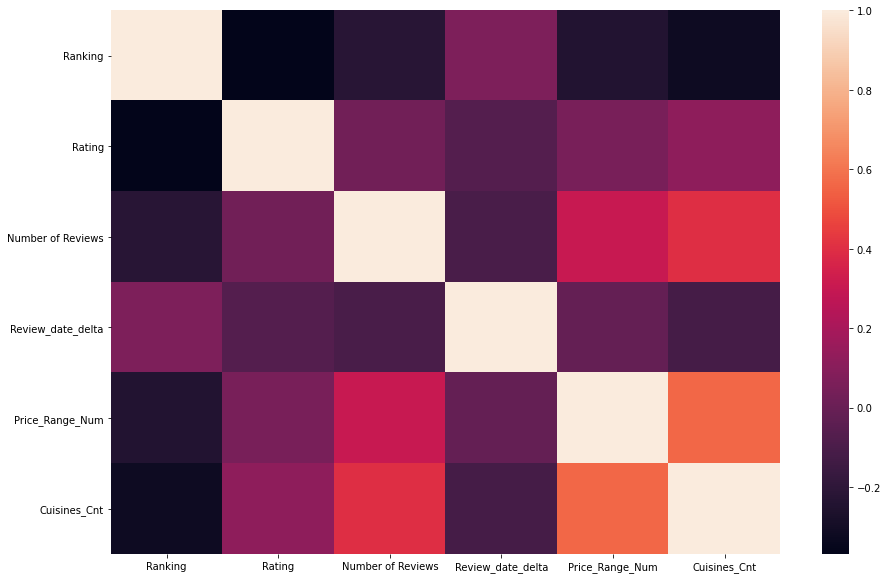

In [57]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df_train.corr(),)

Ну что можно сказать - чем разнообразнее меню (больше разных кухонь) - тем больше отзывов и выше цены в ресторане. И если с первым всё понятно, то второе... Хотя... Надо же платить повару, который знает редкую кухню, и которую редко заказывают? Надо. А значит - надо на это дело откуда-то взять деньги :)

In [58]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df_train.drop(
    ['Restaurant_id', 'City', 'Cuisine Style', 'Rating', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'Cuisines', 'Review_date', 'Review_text'
     ], axis=1
)
y = df_train['Rating']

# Заполняем пропуски
X = X.fillna(0)

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.3810032067460318


# ВТОРАЯ ПОПЫТКА

In [59]:
# Делаем числовые метки кухонь - отдельными колонками
for item in cuisines:
    df_train[item] = df_train['Cuisines'].apply(find_item)

In [60]:
# Города

# делаем список городов
cities = []  # создаём пустой список для хранения уникальных значений городов
city_list = df_train['City']  # колонка с городами
for i in range(len(city_list)):  # перебираем города
    if not(city_list[i] in cities):  # новая запись
        cities.append(city_list[i])  # добавляем его к списку cities

# делаем цифровые метки-колонки под города
for item in cities:
    df_train[item] = df_train['City'].apply(find_item)

In [61]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df_train.drop(
    ['Restaurant_id', 'City', 'Cuisine Style', 'Rating', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'Cuisines', 'Review_date', 'Review_text'
     ], axis=1
)
y = df_train['Rating']

# Заполняем пропуски
X = X.fillna(0)

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21336


In [62]:
# В принципе - достаточно:
# разброс оценок - половина балла (см. data['Rating'].value_counts())
# то есть эту половину можно принять за единичное деление шкалы прибора, измеряющего рейтинг :)
# ну а так как точность любого прибора - половина единичного деления шкалы измерения
# то всё, что меньше 0.25 - уже достаточно точное
# добавлять разбивку по странам или регионам Европы - даст маленький результат: потому что они оба зависят от городов
# можно добавить размеры/количество жителей городов - но на это уже не осталось времени. Жаль :(

# Визуализации

<AxesSubplot:>

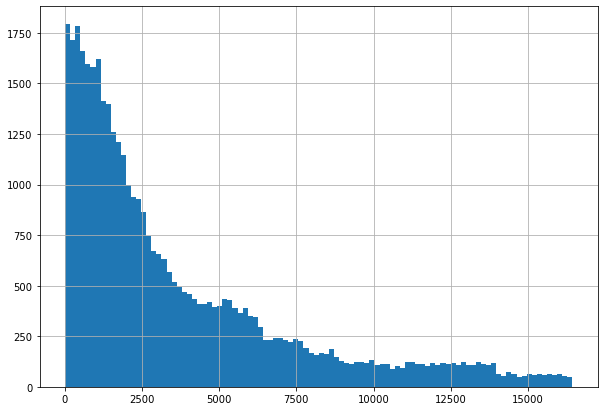

In [63]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

чем выше ресторан в рейтинге - тем ожесточённее борьба.

<AxesSubplot:>

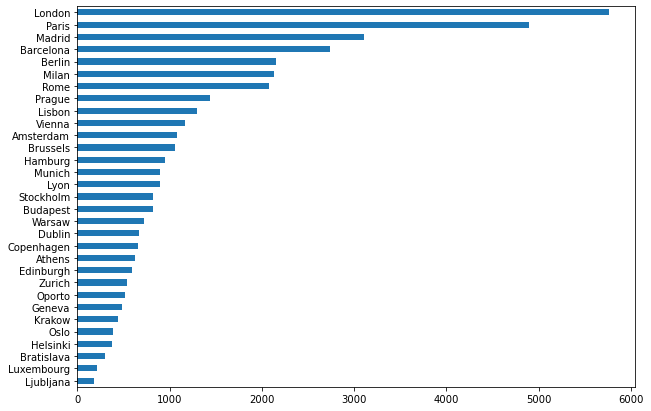

In [64]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Чем крупнее город - тем больше в нём ресторанов